# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


# database = '../data/IoT.db'
# database = '../data/TinyVul.db'
database = "/Users/guru/research/TinyVul-v2.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [2]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')

dfplt['category'] = dfplt.apply(lambda row: row['category'] 
if row['category']==row['name'] or row['name']=='-' 
else row['name'], axis=1)
dfplt = dfplt.drop(labels=['name'], axis=1)

fig = px.sunburst(dfplt, 
    path=['category', 'cwe'], 
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [3]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,cwe,count
61,memcpy,CWE-120,21092
50,char,CWE-119!/CWE-120,16318
66,sprintf,CWE-120,6034
71,strlen,CWE-126,4326
70,strcpy,CWE-120,2187
63,read,"CWE-120, CWE-20",2085
37,uninitvar,CWE-457,1445
13,integerOverflow,CWE-190,1434
97,open,CWE-362,1280
81,printf,CWE-134,879


# Top 10 vulnerabilities

In [4]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+-----------------+------------------+---------+
|    | category        | cwe              |   count |
|----+-----------------+------------------+---------|
|  0 | memcpy          | CWE-120          |   21092 |
|  1 | char            | CWE-119!/CWE-120 |   16318 |
|  2 | sprintf         | CWE-120          |    6034 |
|  3 | strlen          | CWE-126          |    4326 |
|  4 | strcpy          | CWE-120          |    2187 |
|  5 | read            | CWE-120, CWE-20  |    2085 |
|  6 | uninitvar       | CWE-457          |    1445 |
|  7 | integerOverflow | CWE-190          |    1434 |
|  8 | open            | CWE-362          |    1280 |
|  9 | printf          | CWE-134          |     879 |
+----+-----------------+------------------+---------+


<AxesSubplot: >

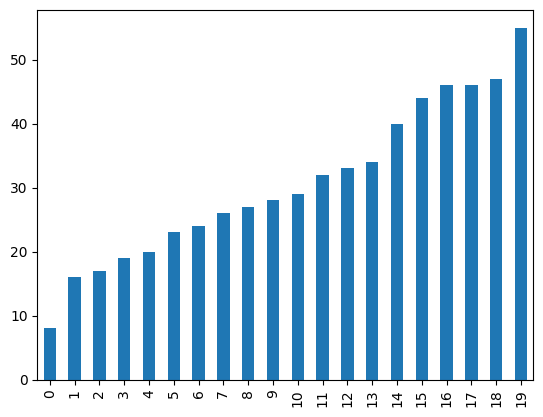

In [5]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

<AxesSubplot: ylabel='Frequency'>

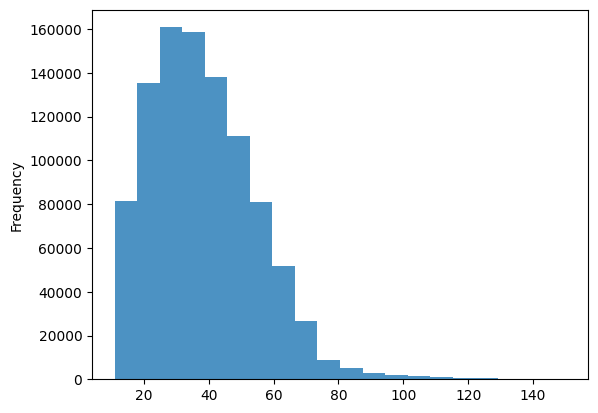

In [44]:
dfs = dfs[dfs.context.str.len()<151]
pd.Series([len(x) for x in dfs.context if len(x)>10]).plot.hist(xlabel='#chars', bins=20, ylabel='#statements',alpha=0.8)

In [45]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 151  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[29, 41, 23, 69, 10]

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [49]:
# # for project-wise distribution
# projects = list(dfs.project.unique())

# for project in projects:
#     print(project)
#     df = dfs[dfs.project == project]
#     print(df.shape)
#     # print(df.cwe.value_counts())
#     # print(df.category.value_counts())
#     print('----------------------')

## Create a latex table from the statistics of projects

In [50]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))
prj_s

count
project     cwe               
ARMmbed     Benign       37690
            Vulnerable    5963
FreeRTOS    Benign       37931
            Vulnerable    4375
RIOT        Benign       13349
            Vulnerable    2357
contiki     Benign        3741
            Vulnerable     977
gnucobol    Benign        8828
            Vulnerable    1356
linux-rpi   Benign      772021
            Vulnerable   44613
micropython Benign       35333
            Vulnerable    3645
openwrt     Benign        6505
            Vulnerable     848
tinyos      Benign        2249
            Vulnerable     410

In [51]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [52]:
# make class binary type benign/vulnerable
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
       cwe &  count \\
\midrule
Vulnerable &  66119 \\
\bottomrule
\end{tabular}
\end{table}



In [53]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['project','cwe']).sum()
prj_s

count
project                                cwe                    
/Users/guru/research/projects//contiki Benign             3741
                                       CWE-119!/CWE-120    398
                                       CWE-120             369
                                       CWE-120, CWE-20      27
                                       CWE-126              85
...                                                        ...
/Users/guru/research/projects/tinyos   CWE-570               6
                                       CWE-676               1
                                       CWE-768               1
                                       CWE-807, CWE-20       2
                                       CWE-unknown           9

[202 rows x 1 columns]

# Show the description of the function-level data

In [54]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)

# shortening the project URL to project name only 
df_freq['top'] = df_freq.apply(lambda row:row['top'].split('/')[-1] if '/' in row['top'] else row['top'], axis=1)

# The freq is the most common value’s frequency. The top is the most common value.
print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False,
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &       top &   freq \\
\midrule
 context &  45848 &           & 480357 \\
     cwe &      2 &    Benign & 480357 \\
 project &      9 & linux-rpi & 456380 \\
\bottomrule
\end{tabular}
\end{table}



In [55]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 982191
Size of unique statements: 981853

Size of functions: 546476
Size of unique functions: 537853


# ML-specific: Convert hyperparameters list to latex table format

In [63]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config/classifier.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
 hyperparameter &                    value \\
\midrule
         epochs &                       50 \\
   debug\_epochs &                        3 \\
          batch &                      128 \\
   input\_length &                      150 \\
      input\_dim &                      150 \\
     output\_dim &                       32 \\
             lr &                     1e-4 \\
       patience &                       35 \\
      optimizer &                     adam \\
         l2\_reg &                     1e-4 \\
        dropout &                      0.0 \\
  recur\_dropout &                      0.0 \\
         beta\_1 &                      0.9 \\
         beta\_2 &                    0.999 \\
        epsilon &                    1e-08 \\
          decay &                      0.0 \\
        verbose &                        2 \\
loss\_multiclass & c